In [ ]:
!pip install torchgeo torchvision torch

In [ ]:
!pip install rasterio

In [ ]:
from torchgeo.datasets import EuroSAT


# Charger le dataset EuroSAT
dataset = EuroSAT(root="data", download=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import rasterio
from torch.utils.data import Dataset, DataLoader
import glob
import os

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Chargement du modèle DOFA pré-entraîné
model = torch.hub.load('zhu-xlab/DOFA', 'vit_base_dofa', pretrained=True).to(device)

# Sauvegarde des anciens poids et biais de la tête pré-entraînée
pretrained_weights = model.head.weight.clone()
pretrained_bias = model.head.bias.clone()

num_classes = 10

model.head = nn.Linear(model.head.in_features, num_classes).to(device)  # Adapter pour 10 classes EuroSAT

# Initialisation des nouveaux poids en copiant les anciens pour éviter l'initialisation aléatoire complète
with torch.no_grad():
    model.head.weight[:num_classes] = pretrained_weights[:num_classes]
    model.head.bias[:num_classes] = pretrained_bias[:num_classes]

#  Pour normalisation Sentinel-2
S2_MEAN= torch.tensor([1354.4061, 1118.2440, 1042.9303,  947.6266, 1199.4730, 1999.7909,
        2369.2234, 2296.8264,  732.0832,   12.1133, 1819.0110, 1118.9241,
        2594.1421],dtype=torch.float32)
S2_STD= torch.tensor([245.7125,  333.0079,  395.0908,  593.7499,  566.4167,  861.1826,
        1086.6309, 1117.9812,  404.9203,    4.7758, 1002.5856,  761.3032,
        1231.5829], dtype=torch.float32)
wavelengths = torch.tensor([0.443, 0.490, 0.560, 0.665, 0.705, 0.740, 0.783, 0.842, 0.865, 0.945, 1.375, 1.610, 2.190], dtype=torch.float32).to(device)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/zhu-xlab/DOFA/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://huggingface.co/earthflow/DOFA/resolve/main/DOFA_ViT_base_e100.pth" to /root/.cache/torch/hub/checkpoints/DOFA_ViT_base_e100.pth
100%|██████████| 427M/427M [00:06<00:00, 74.2MB/s]


In [ ]:
#  Classe pour chargement et prétraitement des images
class Sentinel2Dataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        #On charge la liste des fichiers images à partir du fichier texte (un fichier par ligne)
        self.file_list = [line.strip() for line in open(file_list, 'r')]
        self.root_dir = root_dir #dossier qui cntient lesimages
        self.transform = transform #transformations
        self.label_map = {cls: idx for idx, cls in enumerate(["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
                                                              "Industrial", "Pasture", "PermanentCrop", "Residential",
                                                              "River", "SeaLake"])}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
      # Récupère le nom du fichier image à l'index donné
        img_name = self.file_list[idx]
        class_name = img_name.split('_')[0]  # Extraire la classe depuis le nom du fichier
        img_path = os.path.join(self.root_dir, class_name, img_name.replace(".jpg", ".tif")) #chemin vers l'image

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)

        img = torch.from_numpy(img)  # Convertir en tensor
        label = self.label_map[class_name]  # Obtenir l'index de classe
        #applique les transfo
        if self.transform:
            img = self.transform(img)

        return img, label

#  Définition des transformations
class DataAugmentation(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.transform = transforms.Compose([
            #Découpe aléatoire et redimensionnement de l'image à 224x224
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0)),
            #Normalisation
            transforms.Normalize(mean=mean, std=std)
        ])

    def forward(self, x):
       # Applique les transformations à l'image
        return self.transform(x)
#On applique ces transformations aux images en utilisant les valeurs de moyenne et d'écart-type de Sentinel-2
transform = DataAugmentation(mean=S2_MEAN, std=S2_STD)

In [ ]:
#  Chargement des datasets
data_dir = "data/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/"
dir_fic_txt="data/"
trainset = Sentinel2Dataset(os.path.join(dir_fic_txt, "eurosat-train.txt"), data_dir, transform=transform)
valset = Sentinel2Dataset(os.path.join(dir_fic_txt, "eurosat-val.txt"), data_dir, transform=transform)
testset = Sentinel2Dataset(os.path.join(dir_fic_txt, "eurosat-test.txt"), data_dir, transform=transform)

#  Création des DataLoaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(valset, batch_size=128, shuffle=False)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

#  Affichage des proportions
nombre_samples = len(trainset) + len(valset) + len(testset)
print(f"- Train set: {len(trainset)*100/nombre_samples:.2f}% ({len(trainset)} images)")
print(f"- Val set: {len(valset)*100/nombre_samples:.2f}% ({len(valset)} images)")
print(f"- Test set: {len(testset)*100/nombre_samples:.2f}% ({len(testset)} images)")

- Train set: 60.00% (16200 images)
- Val set: 20.00% (5400 images)
- Test set: 20.00% (5400 images)


In [ ]:
#  Définition de la fonction de perte et de l’optimiseur
criterion = nn.CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False

# Débloquer uniquement la tête de classification
for param in model.head.parameters():
    param.requires_grad = True

# Optimiseur pour la tête du modèle seulement
optimizer = optim.SGD(model.head.parameters(), lr=1e-3,momentum=0.9,weight_decay=5e-4)

Epoch 1/25 [Training]:   0%|          | 0/254 [00:00<?, ?it/s]/root/.cache/torch/hub/zhu-xlab_DOFA_master/dofa_v1.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavelist = torch.tensor(wave_list, device=x.device).float()


Epoch 1/25, Train Loss: 1.317949, Train Acc: 0.6035, Val Loss: 0.996152, Val Acc: 0.7048


Epoch 2/25, Train Loss: 0.882458, Train Acc: 0.7604, Val Loss: 0.811336, Val Acc: 0.7791


Epoch 3/25, Train Loss: 0.752103, Train Acc: 0.7998, Val Loss: 0.712596, Val Acc: 0.8030


Epoch 4/25, Train Loss: 0.669531, Train Acc: 0.8221, Val Loss: 0.667575, Val Acc: 0.8044


Epoch 5/25, Train Loss: 0.624188, Train Acc: 0.8311, Val Loss: 0.613192, Val Acc: 0.8256


Epoch 6/25, Train Loss: 0.587680, Train Acc: 0.8419, Val Loss: 0.583376, Val Acc: 0.8376


Epoch 7/25, Train Loss: 0.552939, Train Acc: 0.8512, Val Loss: 0.559338, Val Acc: 0.8407


Epoch 8/25, Train Loss: 0.530304, Train Acc: 0.8535, Val Loss: 0.530278, Val Acc: 0.8526


Epoch 9/25, Train Loss: 0.504997, Train Acc: 0.8594, Val Loss: 0.515758, Val Acc: 0.8589


Epoch 10/25, Train Loss: 0.492915, Train Acc: 0.8652, Val Loss: 0.496928, Val Acc: 0.8631


Epoch 11/25, Train Loss: 0.473200, Train Acc: 0.8706, Val Loss: 0.478125, Val Acc: 0.8709


Epoch 12/25, Train Loss: 0.463503, Train Acc: 0.8720, Val Loss: 0.476549, Val Acc: 0.8769


Epoch 13/25, Train Loss: 0.451952, Train Acc: 0.8774, Val Loss: 0.452885, Val Acc: 0.8741


Epoch 14/25, Train Loss: 0.443435, Train Acc: 0.8751, Val Loss: 0.447903, Val Acc: 0.8657


Epoch 15/25, Train Loss: 0.433053, Train Acc: 0.8790, Val Loss: 0.455204, Val Acc: 0.8706


Epoch 16/25, Train Loss: 0.423083, Train Acc: 0.8815, Val Loss: 0.431193, Val Acc: 0.8800


Epoch 17/25, Train Loss: 0.413916, Train Acc: 0.8853, Val Loss: 0.423017, Val Acc: 0.8780


Epoch 18/25, Train Loss: 0.410487, Train Acc: 0.8875, Val Loss: 0.423992, Val Acc: 0.8848


Epoch 19/25, Train Loss: 0.398634, Train Acc: 0.8882, Val Loss: 0.421585, Val Acc: 0.8780


Epoch 20/25, Train Loss: 0.399446, Train Acc: 0.8870, Val Loss: 0.414110, Val Acc: 0.8839


Epoch 21/25, Train Loss: 0.388963, Train Acc: 0.8907, Val Loss: 0.409856, Val Acc: 0.8809


Epoch 22/25, Train Loss: 0.383284, Train Acc: 0.8918, Val Loss: 0.403829, Val Acc: 0.8926


Epoch 23/25, Train Loss: 0.377367, Train Acc: 0.8968, Val Loss: 0.403266, Val Acc: 0.8861


Epoch 24/25, Train Loss: 0.379896, Train Acc: 0.8917, Val Loss: 0.390324, Val Acc: 0.8898


Epoch 25/25, Train Loss: 0.364775, Train Acc: 0.8983, Val Loss: 0.382473, Val Acc: 0.8931


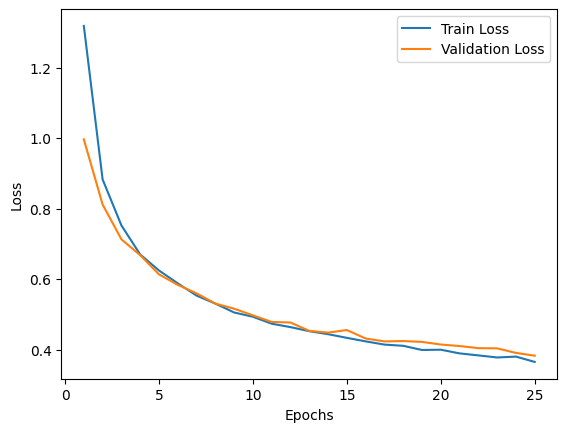

In [ ]:
from tqdm import tqdm
#  Entraînement du modèle
num_epochs = 25
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # calculer la perte totale de l'époque
    correct, total = 0, 0 # Variables pour calculer le nombre de prédictions correctes et le total

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Réinitialiser les gradients avant la rétropropagation
        outputs = model(images, wave_list=wavelengths)  # DOFA
        loss = criterion(outputs, labels) # Calculer la perte (difference entre prédictions et vraies étiquettes)
        loss.backward() #rétropropagation pour calculer les gradients
        optimizer.step() # Mettre à jour les poids du modèle avec les gradients calculés

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1) # Prendre la classe avec la probabilité maximale
        correct += (predicted == labels).sum().item() # Compter les prédictions correctes
        total += labels.size(0)

        # Mettre à jour la barre de progression
        train_loader_tqdm.set_postfix(loss=loss.item(), acc=correct/total)

    train_loss = running_loss / len(train_loader.dataset)  # Perte moyenne
    train_losses.append(train_loss)
    train_acc = correct / total

    #  Évaluation sur validation
    model.eval()
    running_loss, correct, total = 0.0, 0, 0 # Réinitialiser les variables pour la validation

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, wave_list=wavelengths) #reucp logits

            loss = criterion(outputs, labels) #perte
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Mettre à jour la barre de progression
            val_loader_tqdm.set_postfix(loss=loss.item(), acc=correct/total)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")

#  Affichage de la courbe de loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Calcul des métriques:   0%|          | 0/43 [00:00<?, ?batch/s]/root/.cache/torch/hub/zhu-xlab_DOFA_master/dofa_v1.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavelist = torch.tensor(wave_list, device=x.device).float()
Calcul des métriques: 100%|██████████| 43/43 [01:39<00:00,  2.31s/batch]


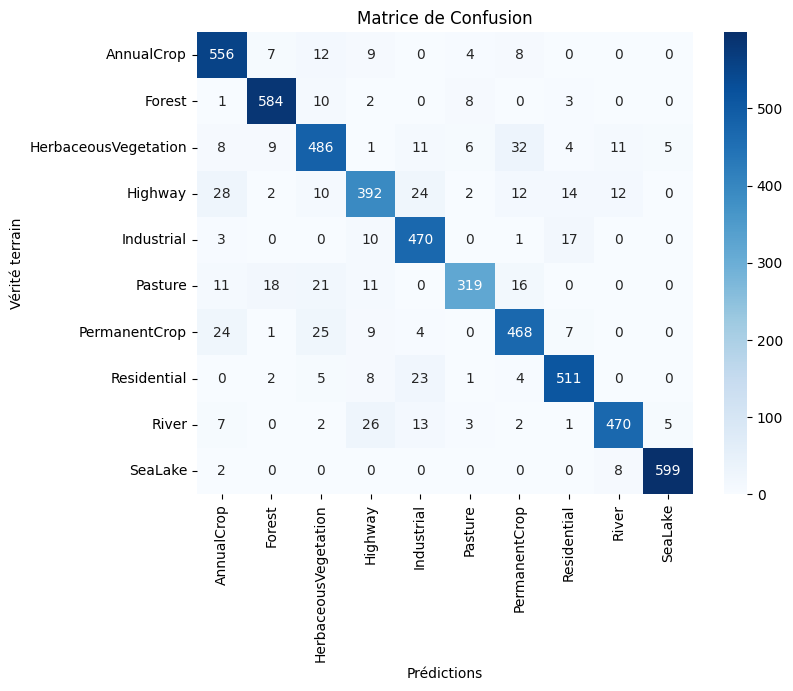

Accuracy: 89.91%
Precision: 0.8997
Recall: 0.8991
F1 Score: 0.8986
Mean Absolute Error (MAE): 0.3365
Mean Squared Error (MSE): 1.4176


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error,confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

#  Calcul des prédictions et des métriques avec une barre de progression
with torch.no_grad():
    model.eval()

    # Utilisation de tqdm pour afficher une barre de progression
    for images, labels in tqdm(test_loader, desc="Calcul des métriques", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images, wave_list=wavelengths)

        # Trouver les indices de la classe prédite
        _, predicted = torch.max(outputs, 1)

        # Enregistrer les prédictions et les labels pour les métriques
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  Création de la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

#  Affichage sous forme de heatmap avec Seaborn
plt.figure(figsize=(8, 6))
class_names = list(testset.label_map.keys())

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de Confusion')
plt.show()

#  Calcul des métriques
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)

# Affichage des résultats
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")